# PoC Use Case 4
## New Peril Score Disparity (Dislocation) Analysis
### Powered by integrate.ai


# **integrate.ai**

integrate.ai's platform, allows its users to collaborate and to perform secure and privacy preserving analytics and machine learning jobs. In this guide, we show case some of the key functionality of integrate.ai's platform to demonstrate

1. integrate.ai's solution for Match Rate Analysis, Exploratory Data Analysis, and Model Validation. 
2. The efficacy of the federated learning platform and the similarity of performance compared to a centralzied solution.
3. Ease of use and seamless integration of integrate's solution into any data science working environment.

# **Use Case Description**

An insurance company is interested in evaluating the changes in the new Peril Score released by a provider to understand whether the distribution change is disruptive to their processes and whether they should upgrade or not

There are two core questions the insurance company's data scientists are interested in answering in evaluating the provider's peril score:

1. **Match Rate:** How much data from the data provider's data product is usable in reference to my internal data?
2. **Relevance:** How different and useful is the new score to their business metrics and processes

This guide seeks to answer these two questions using integrate.ai's platform, and compare the methodology and the results to the scenario where all the data is centralzied and joined in one database. We will start by demonstrating how the match rate can be calculated using IAI's Private Record Linkage. We will then show how a data scientist can use integrate's solution to perform exploratory data analysis to understand the differences in the old and the new score.

# **Setup and Configuration**

If you are on the full simulation PoC package, before running this notebook you should first [install the Integrate.ai components](https://documentation.integrateai.net/#hfl-data-requirements), and complete required setup and configuration for Task Runners. For details, see [Using integrate.ai](https://documentation.integrateai.net/#using-integrate-ai). The notebook is based on two AWS Task Runners simulating the training environment of a **Data Consumer** and **Insurance Carrier Company**, respectively. To set up your Task Runner on Azure refer to https://documentation.integrateai.net/#azure-configuration-for-task-runners
For a more realistic simulation, integrate.ai will set up the partner environment for you and the provider datasets will be shared with you in your IAI workspace. 

If you are on a no installation PoC package, your environment needs to be fully set up by your customer success team. You can check this by looking through the datasets available to you in your IAI workspace. Contact your customer success agent to learn more.

The datasets used in the PoCs are either publicly available or synthetic datasets. You must download these datasets for the centralized analyses. Here is the link to the datasets used in this notebook for this use case:

s3://downloads.integrateai.net/poc/usecase4/


# **Match Rate Analysis**

## **Centralzied**

The centralized match rate is created by loading the two datasets into a dataframe, and performing a join and a count on the two datasets.

In [1]:
import pandas as pd

insurance_train_centralized = pd.read_csv("./consumer_old_peril_train.csv")
insurance_test_centralized = pd.read_csv("./consumer_old_peril_test.csv")

provider_centralized = pd.read_csv("./provider.csv")

overlap_train_centralized = pd.merge(insurance_train_centralized, provider_centralized, how='inner', on=['id'] )
overlap_test_centralized = pd.merge(insurance_test_centralized, provider_centralized, how='inner', on=['id'] )

matchrate_train_centralized =  overlap_train_centralized.shape[0]
matchrate_test_centralized =  overlap_test_centralized.shape[0]


print(matchrate_train_centralized)
print(matchrate_test_centralized)

40000
10000


## **integrate.ai**

integrate.ai's solution calculates the match rate by performing Private Record Linkage (PRL). Overlapping records are determined privately through a PRL session, which combines Private Set Intersection with Private Record Alignment. PRL uses the intersection to create alignment between the different collaborating datasets.

PRL sessions allow the integrate.ai platform to perform match rate analysis by counting the overlapping records, conduct safe analytics by performing secure statistical analysis on the overlap, and train models on the overlap of the participating datasets without exposing the overlap.


### Set environment variables with your IAI credentials

Generate and manage this token in your company's integrate.ai workspace UI.

In [2]:
from integrate_ai_sdk.api import connect
import os
import json

IAI_TOKEN = ""
client = connect(token=IAI_TOKEN)

In [3]:
import json
import pandas as pd
import numpy as np

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

### Set your AWS variables

**Important: The task runner expects your data to be in the bucket that was created when the task runner was provisioned.**

A data scientist can access the data in two ways in the following session. If the dataset is registered with the Task Runner, it can be specified in the session by the dataset name (`train_dataset_name` and `test_dataset_name`). Otherwise, the dataset path should be provided to identify the data, as in the example below.

**Note, the datasets in this notebook are publicly available. The datasets can be registered with your own task runner and fully in your own control, hybrid of your taskrunner and IAI task runners to mimic a real situation, or registered fully with IAI task runners to allow you to move quickly.**

In [4]:
# The path to train and test datasets for both parties
consumer_train_path = 'consumer_old_peril_train'
consumer_test_path = 'consumer_old_peril_test'

provider_train_path = 'provider'
provider_test_path = 'provider'


The task runners used for this notebook are `supplyaws` and `demandaws`. If you are on the full installation PoC package you need to replace the `demandaws` with your own taskrunner name.

In [5]:
from integrate_ai_sdk.taskgroup.taskbuilder.integrate_ai import IntegrateAiTaskBuilder
from integrate_ai_sdk.taskgroup.base import SessionTaskGroup
from integrate_ai_sdk.taskgroup.taskbuilder import taskrunner_context
from integrate_ai_sdk.taskgroup.taskbuilder.integrate_ai import IntegrateAiTaskBuilder
from integrate_ai_sdk.taskgroup.base import SessionTaskGroup
from typing import Iterable, Optional
from integrate_ai_sdk.api import Client
from integrate_ai_sdk.taskgroup.taskbuilder.taskrunner_context import TaskRunnerContext
from integrate_ai_sdk.taskgroup.taskbuilder.taskrunner_task import ClientTask, FLSTask, ClientTaskConfig

iai_tb_aws_provider = IntegrateAiTaskBuilder(client=client,
                                         task_runner_id="supplyaws")

iai_tb_aws_consumer = IntegrateAiTaskBuilder(client=client,
                                       task_runner_id="demandaws")

## Private Record Linkage (PRL)

To facilitate match rate analysis, integrate.ai's Private Record Linkage feature privately joins the features of different clients using a common key - often a global index, or a combination of features that can be matched to identify an individual. Here a client means a participating party that provides dataset to the collaboration.

**Join key**

In this guide notebook, the synthetic data and provider data are linked by a join key (i.e. `oak`), specified as `id_columns` in the data config. For more information on how to configure an PRL session, see the documentation [here](https://documentation.integrateai.net/#prl-session-example).

In [6]:
# Step 1: Specify PRL dataset configuration

prl_data_config = {
    "clients": {
        "consumer_old_peril_train": {
            "id_columns": ["id"],
            "backend": {"name": "dask", "n_data_partitions": 10, "memory_threshold":0.4},
        },
        "provider": {
            "id_columns": ["id"],
            "backend": {"name": "dask", "n_data_partitions": 10, "memory_threshold":0.4},
        },
    },
}

In [7]:
# Step 2: Create and start PRL session

prl_session = client.create_prl_session(
    name="peril score - PRL",
    description="I am running PRL session with synthetic peril score data and the consumer data",
    data_config=prl_data_config
).start()

prl_session.id #Prints the session ID for reference

'c9a6dc15cc'

In [8]:
# Step 3: Create a task group with one task for each client joining the session

task_group = (
    SessionTaskGroup(prl_session)
    .add_task(iai_tb_aws_consumer.prl(train_dataset_name=consumer_train_path, test_dataset_name=consumer_test_path, client_name="consumer_old_peril_train"))\
    .add_task(iai_tb_aws_provider.prl(train_dataset_name=provider_train_path, test_dataset_name=provider_test_path, client_name="provider"))
)

task_group_context = task_group.start()

You can use `task_group_context.contexts.values()` and `task_group_context.monitor_task_logs()` to track and see the taskrunner and orchastration logs. Equivalently, you can see the system logs in the UI under the sessions section.

## **Conclusion**

You can find the result of the match rate analysis in the PRL session metrics or the summary table below. In these results, the client `consumer` represents the match in the consumer data. You can see how the values of overlap between train and test sets matches those of the centralized analysis.

In [32]:
metrics = prl_session.metrics().as_dict()
summary_table = pd.DataFrame(metrics['client_metrics']['consumer_old_peril_train']).T
summary_table

,n_records,n_overlapped_records,frac_overlapped
train,40000.0,40000.0,1.0
test,10000.0,10000.0,1.0


In [33]:
print(matchrate_train_centralized)
print(matchrate_test_centralized)

40000
10000


## **Common Feature Analysis**
In order to understand the changes in the scores
1. We will perform exploratory analysis on top of the scores columns to understand the differences between the two features.
2. We will perform exploratory analysis on top of the scores columns for the records that differ on their scores.
3. We will perform model training to understand the value of the new score compared to the older version of the score.



## **Exploratory Data Analysis**



## **Centralized**

In [65]:
overlap_train_centralized[["fire_old","fire"]].corr()

,fire_old,fire
fire_old,1.000000,0.981304
fire,0.981304,1.000000


In [79]:
overlap_train_centralized[["loss_amount_log","fire"]].corr()

,loss_amount_log,fire
loss_amount_log,1.000000,0.305366
fire,0.305366,1.000000


In [43]:
overlap_train_centralized[["loss_amount_log","fire_old"]].corr()

,loss_amount_log,fire_old
loss_amount_log,1.000000,0.299784
fire_old,0.299784,1.000000


## **integrateai**

In [70]:
eda_data_config = {"consumer_old_peril_train": [], "provider": []}
paired_columns = {"consumer_old_peril_train":["fire_old","loss_amount_log"], "provider":["fire"]}


In [71]:
eda_session = client.create_eda_session(
    name="peril score - EDA intersect",
    description="I am running a EDA intersect session",
    data_config=eda_data_config,
    eda_mode="intersect",
    paired_columns=paired_columns,
    hide_intersection=False,
    prl_session_id=prl_session.id
).start()

eda_session.id

'aa5a12b297'

In [72]:
task_group = (
    SessionTaskGroup(eda_session)
    .add_task(iai_tb_aws_consumer.eda(dataset_name=consumer_train_path, job_timeout_seconds= 10*60*60))\
    .add_task(iai_tb_aws_provider.eda(dataset_name=provider_train_path, job_timeout_seconds= 10*60*60))
)

task_group_context = task_group.start()

In [49]:
results = eda_session.results()

In [77]:
consumer = results['consumer_old_peril_train']
provider = results['provider']
results.corr(consumer['fire_old'],provider['fire'])



,consumer_old_peril_train@fire_old,provider@fire
consumer_old_peril_train@fire_old,1.000000,0.780078
provider@fire,0.780078,1.000000


In [78]:
results.corr(consumer['loss_amount_log'],provider['fire'])


,consumer_old_peril_train@loss_amount_log,provider@fire
consumer_old_peril_train@loss_amount_log,1.000000,0.220161
provider@fire,0.220161,1.000000


## **Model Performance**

We will train two models, one with only the old scores available at the carrier and the other with the new scores in the provider data. If the new score is better than the old one we should see a performance improvement on the provider score model compared to the consumer score model.

In [20]:
provider_features_base = []

consumer_features_base = ['policy_type', 'renewed', 'deductible', 'Premium',
                         'total_old_norm', 'crime_old_norm', 'fire_old_norm', 'other_old_norm',
       'sewer_old_norm', 'water_old_norm', 'windhail_old_norm']


provider_features_challenger = [ 'total_norm', 'crime_norm', 'fire_norm', 'other_norm',
       'sewer_norm', 'water_norm', 'windhail_norm']
consumer_features_challenger = ['policy_type', 'renewed', 'deductible', 'Premium']

target = "loss_amount_log"

### **Centralized**

#### **Base Model**

In [21]:
X_train_base = insurance_train_centralized[consumer_features_base]
y_train_base = insurance_train_centralized[target]

X_test_base = insurance_test_centralized[consumer_features_base]
y_test_base = insurance_test_centralized[target]

In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor

# run this part if you want to use generalized linear model as your model type
baseline = SGDRegressor()

baseline.fit(X_train_base, y_train_base)

# Print the number of iterations
print('Number of iterations =', baseline.n_iter_)

y_pred_base = baseline.predict(X_test_base)

from sklearn.metrics import r2_score

r2_base = r2_score(y_test_base, y_pred_base)
r2_base

Number of iterations = 13


0.267101463171986

#### **Challenger Model**

In [23]:
X_train_challenger = overlap_train_centralized[consumer_features_challenger+provider_features_challenger]
y_train_challenger = overlap_train_centralized[target]

X_test_challenger = overlap_test_centralized[consumer_features_challenger+provider_features_challenger]
y_test_challenger = overlap_test_centralized[target]

In [24]:
challenger = SGDRegressor()

challenger.fit(X_train_challenger, y_train_challenger)

# Print the number of iterations
print('Number of iterations =', baseline.n_iter_)

y_pred_challenger = challenger.predict(X_test_challenger)


r2_challenger = r2_score(y_test_challenger, y_pred_challenger)
r2_challenger

Number of iterations = 13


0.27306053353841564

### **integrateai**

#### **Challenger Model**

In [25]:
model_config = {
     "strategy": {"name": "VflGlm", "params": {}},
     "model": {
         "provider": {"params": {"input_size": len(provider_features_challenger), "output_activation": None}},
         "consumer_old_peril_train": {"params": {"input_size": len(consumer_features_challenger), "output_activation": None}},
     },
     "ml_task": {
         "type": "normal",
         "params": {},
     },
     "optimizer": {"name": "SGD", "params": {"learning_rate": 0.1, "momentum": 0.0}},
     "feature_importance_score": {"enable": True, "params": {"max_evals": 200, "subsample":0.5, "random_seed": 23}},
     "seed": 23,  # for reproducibility
 }
data_config = {
        "provider": {
            "label_client": False,
            "predictors": provider_features_challenger,
            "target": None,
        },
        "consumer_old_peril_train": {
            "label_client": True,
            "predictors": consumer_features_challenger,
            "target": target,
        },
    }

consumer_storage_path = 's3://demand-demandaws.integrate.ai/model'
provider_storage_path = 's3://supply-supplyaws.integrate.ai/model'

In [26]:
fl_train_session = client.create_vfl_session(
    name="peril score - VFL model Train",
    description="I am train a federated model with peril score and the consumer data",
    prl_session_id=prl_session.id,
    vfl_mode='train',
    min_num_clients=2,
    num_rounds=20,
    package_name="iai_glm", 
    data_config=data_config,
    model_config=model_config
).start()

In [27]:
vfl_task_group_context = (SessionTaskGroup(fl_train_session)\
    .add_task(iai_tb_aws_consumer.vfl_train(train_dataset_name=consumer_train_path,
                                    test_dataset_name=consumer_test_path,
                                    client_name="consumer_old_peril_train",
                                    batch_size=4096,
                                    storage_path=consumer_storage_path,
                                    memory= str(32 * 1024),
                                    job_timeout_seconds= 10*60*60))\
    .add_task(iai_tb_aws_provider.vfl_train(train_dataset_name=provider_train_path,
                                    test_dataset_name=provider_test_path,
                                    client_name="provider",
                                    batch_size=4096,
                                    storage_path=provider_storage_path,
                                    memory= str(32 * 1024),
                                    job_timeout_seconds= 10*60*60))\
    .start())

In [41]:
fl_metrics = fl_train_session.metrics()
r2_fed = list(fl_metrics.client_metrics[-1].values())[0]["test_r2"]

## **Conclusions**
Here is the comparison between the $R2$ score of the differnt models. 

<Axes: >

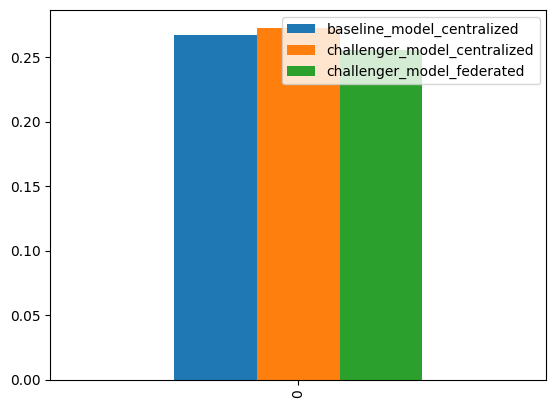

In [42]:
results = dict(baseline_model_centralized=r2_base, challenger_model_centralized=r2_challenger, challenger_model_federated=r2_fed)
results_df = pd.DataFrame(results,index=[0])
results_df.plot.bar()